# Imports

In [85]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import cv2
import os
from importlib import reload
from glob import glob
import face_aligner as temp_fa
from face_aligner import FaceAligner
reload(temp_fa)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig


# Normalize Input Images:

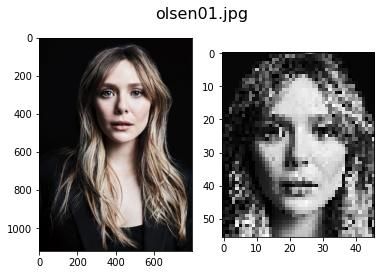

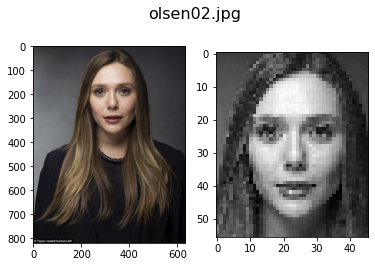

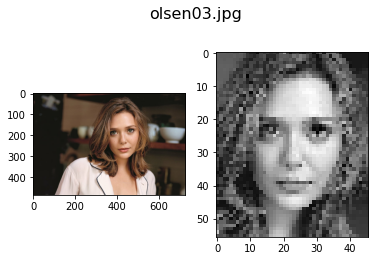

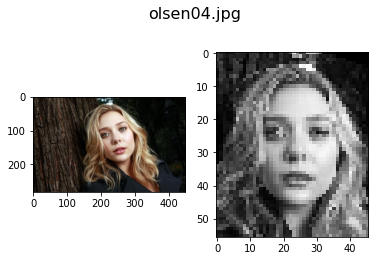

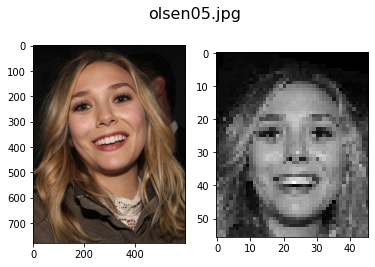

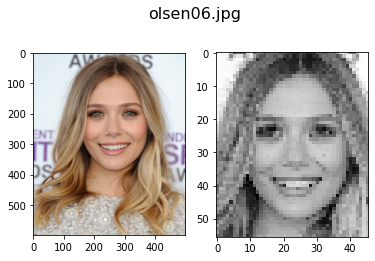

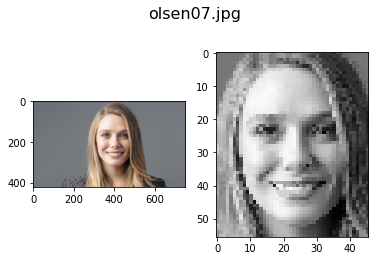

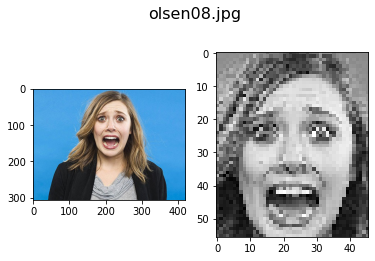

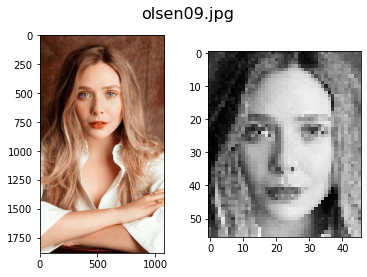

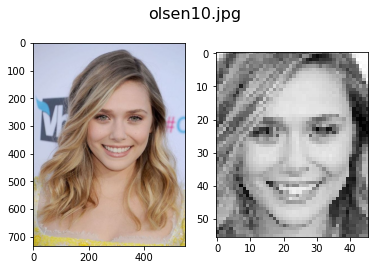

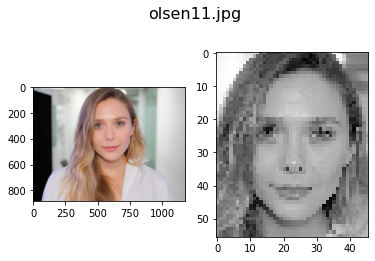

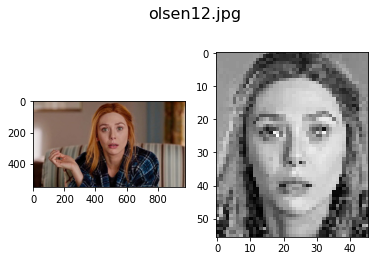

In [3]:
def normalize(file, expected_eye_portion=0.1, eye_scale_factor=1.2, eye_min_neighbors=3):
    image = cv2.imread(file)
    face_aligner = FaceAligner(expected_eye_portion=expected_eye_portion,
                                  eye_scale_factor=eye_scale_factor, eye_min_neighbors=eye_min_neighbors)
    image = face_aligner.align(cv2.cvtColor(
        image, cv2.COLOR_BGR2GRAY))
    return image

def normalize_directory(directory, expected_eye_portion=0.1, eye_scale_factor=1.2, eye_min_neighbors=3, write_to_file=False):
    i = 0
    for file in glob(directory):
        i += 1
        image = cv2.imread(file)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(os.path.basename(file), fontsize=16)
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        face_aligner = FaceAligner(expected_eye_portion=expected_eye_portion,
                                      eye_scale_factor=eye_scale_factor, eye_min_neighbors=eye_min_neighbors)
        image = face_aligner.align(cv2.cvtColor(
            image, cv2.COLOR_BGR2GRAY))
        if image is not None:
            ax2.imshow(image, cmap='gray')
            new_file_name = os.path.join('dataset', os.path.basename(file))
            if write_to_file:
                cv2.imwrite(new_file_name, image)


def detect_faces_and_eyes(directory, expected_eye_portion=0.1, eye_scale_factor=1.2, eye_min_neighbors=3):
    for file in glob(directory):
        image = cv2.imread(file)
        face_aligner = FaceAligner(expected_eye_portion=expected_eye_portion, eye_scale_factor=eye_scale_factor, eye_min_neighbors=eye_min_neighbors)
        faces = face_aligner.findFaces(image)
        for face, x, y in faces:
            plt.figure()
            plt.imshow(face, cmap='gray')
            eyes = face_aligner.findEyes(face)
            for (x, y, w, h) in eyes:
                plt.figure()
                plt.imshow(face[y:y+h, x:x+w], cmap='gray')
                

normalize_directory('olsen/*.jpg', 0.16, 2.3, 3)
#normalize_directory('cumberbatch/*', 0.18, 1.06, 3)
#normalize_directory('cillian/*', 0.18, 1.05, 3)
    

# Load the Dataset

In [73]:
x1 = []
y1 = []

files = glob('dataset/*')
for file in files:
    image = cv2.imread(file)  # Load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Gray scale
    x1.append(np.array(image))
    y1.append(''.join([i for i in os.path.splitext(os.path.basename(file))[0] if not i.isdigit()]))

x1 = np.array(x1)
y1 = np.array(y1)
n, h, w = x1.shape

print('Images: ' + str(n))
print('Width: ' + str(w) + 'px')
print('Height: ' + str(h) + 'px')

Images: 57
Width: 46px
Height: 56px


# Analyze and Prepare the Dataset:

(57, 2576)
Reshape...
(57, 2576)


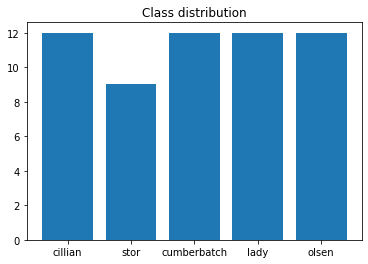

In [77]:
def count_frequency(my_list):
    """
    Returns a dictionary containing each different 
    element as key, and their frequency as value.
    """
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

# Plot class distribution
plt.figure()
freq = count_frequency(y1)
plt.bar(freq.keys(), freq.values())
plt.title("Class distribution")

# Shuffle train data (for better training results)
idx = rd.permutation(x1.shape[0])
x1 = x1[idx]
y1 = y1[idx]

print(x1.shape)
x1 = x1.reshape((n, w*h))*1.
print("Reshape...")
print(x1.shape)


# Split the dataset

(47, 2576) (47,)
(10, 2576) (10,)


Text(0.5, 1.0, 'Test class distribution')

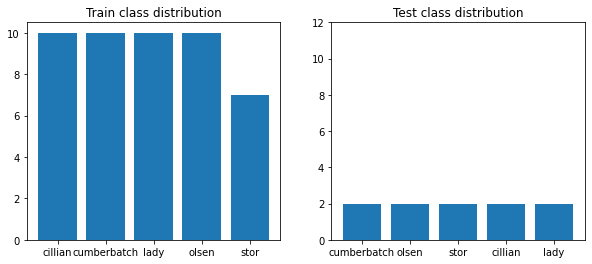

In [118]:
from sklearn.model_selection import train_test_split


def plot(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.colorbar()


def plot_flat(image):
    plot(image.reshape((56, 46)))


X_train, X_test, y_train, y_test = train_test_split(
    x1, y1, test_size=10, stratify=y1)  # Guarantee at least one class in test set

# Randomize train set
idx = rd.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

# Order test set
idx = np.argsort(y_train)
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

# Plot class distribution
plt.ylim(0, 12)
freq = count_frequency(y_train)
ax[0].bar(freq.keys(), freq.values())
ax[0].set_title("Train class distribution")

# Plot class distribution
plt.ylim(0, 12)
freq = count_frequency(y_test)
ax[1].bar(freq.keys(), freq.values())
ax[1].set_title("Test class distribution")


# Test - Predict class of normalized image array (without applying eigenfaces or fisherfaces)

Confusion matrix, without normalization
Score = 0.9
Number of errors = 1


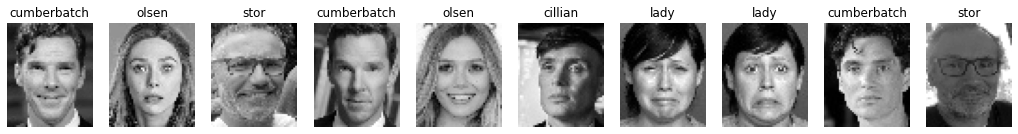

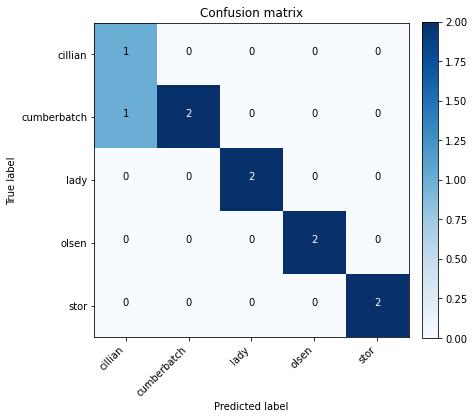

In [119]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

sgd = SGDClassifier().fit(X_train, y_train)
y_p = sgd.predict(X_test)

fig, ax = plt.subplots(1, X_test.shape[0])

fig.set_figheight(4)
fig.set_figwidth(18)

for i in range(X_test.shape[0]):
    ax[i].imshow(X_test[i].reshape((56, 46)), cmap='gray')
    ax[i].set_title(y_p[i])
    ax[i].axis('off')

plot_confusion_matrix(confusion_matrix(y_p, y_test), classes=np.unique(y_test))

print('Score = ' + str(sgd.score(X_test, y_test)))
print('Number of errors = ' + str(np.sum(y_test != y_p)))

# EigenFaces 

m+1 obtained vectors form an orthogonal basis: True



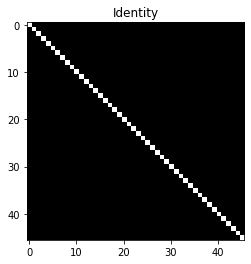

In [181]:
def eigen(X_train_eigen, print_orthogonal_basis=False):
    # Get mean face
    mean_face = np.zeros(56*46)
    for i in X_train_eigen:
        mean_face = np.add(mean_face, i)
    mean_face = np.divide(mean_face, X_train_eigen.shape[0])
    #plot_flat(mean_face)

    # Subtract mean face from all faces
    for i in range(X_train_eigen.shape[0]):
        X_train_eigen[i] = X_train_eigen[i] - mean_face

    # AC components
    A = X_train_eigen.T
    R = A.T.dot(A)
    w, v = np.linalg.eig(R)

    # Select N-1 eigenvectors
    idx = np.argsort(w)
    w = w[idx]
    v = v[:, idx]

    w = w[1:]
    v = v[:, 1:]
    W = A.dot(v)
    
    # Divide each W column by its norm
    for i in range(W.shape[1]):
        W[:, i] = np.divide(W[:, i], np.linalg.norm(W[:, i]))

    # Check if obtained vectors form an orthogonal basis
    if (print_orthogonal_basis):
        identity = W.T.dot(W)
        print('m+1 obtained vectors form an orthogonal basis: ' +
            str(np.allclose(identity, np.identity(identity.shape[0]))) + '\n')
        plt.imshow(identity, cmap="gray")
        plt.title('Identity')
        #print(identity)

    # Face classifier
    return mean_face, W, W.T.dot(A)


mean_face_train, W_train, Y_train = eigen(
    X_train.copy(), print_orthogonal_basis=True)


Error face is orthogonal to face subspace: True


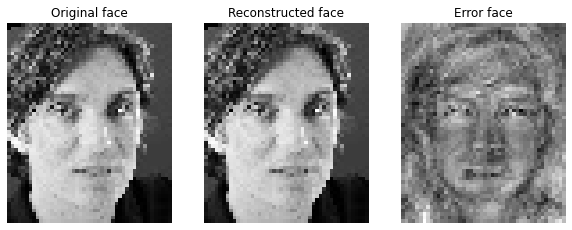

In [188]:
example_face = X_train[0]

# Reconstruct
Xp = W_train.dot(Y_train)
Xp = Xp.T

# Add mean face to all reconstructed faces
for i in range(Xp.shape[0]):
    Xp[i] = Xp[i] + mean_face_train

reconstructed_face = Xp[0].copy()
error_face = example_face - reconstructed_face

fig, ax = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(10)

ax[0].imshow(example_face.reshape((56, 46)), cmap='gray')
ax[0].set_title('Original face')
ax[0].axis('off')

ax[1].imshow(reconstructed_face.reshape((56, 46)), cmap='gray')
ax[1].set_title('Reconstructed face')
ax[1].axis('off')

ax[2].imshow(error_face.reshape((56, 46)), cmap='gray')
ax[2].set_title('Error face')
ax[2].axis('off')

# Error face is orthogonal to face subspace if its classifier is all zeros
ye = W_train.T.dot(error_face)
print('Error face is orthogonal to face subspace: ' + str(np.allclose(ye, np.zeros(ye.shape))))

# Classification
#! yz = W.T.dot(z - mean_face)
# distancia euclideana entre yz com Y
# a menor distancia é a escolhida


# Classify test set with Eigen Faces

To classify, a custom Nearest-Neighbor (NN) classifier will be used.

Y_train (47, 46)
Y_test (10, 46)
Confusion matrix, without normalization


"print('Score = ' + str(sgd.score(X_test, y_test)))\nprint('Number of errors = ' + str(np.sum(y_test != y_p)))"

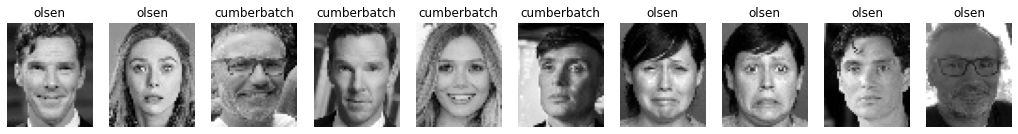

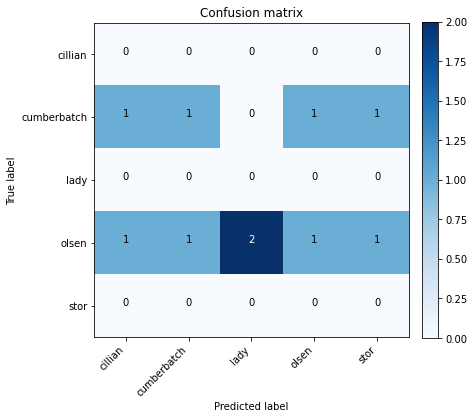

In [214]:
class NearestNeighbour:
    def __init__(self, X_train, y_train): 
        _, self.W_train, self.Y_train = eigen(
            X_train.copy())
        self.Y_train = Y_train.T
        self.y_train = y_train
    
    def predict(self, X_test):
        self.Y_test = X_test.dot(self.W_train)
        print('Y_train ' + str(self.Y_train.shape))
        print('Y_test ' + str(self.Y_test.shape))
        y_p = []
        for vector_test in self.Y_test:  # classify each test
            euclidian_distances = []
            for vector_train in self.Y_train:  # check for best neighbour in train
                euclidian_distances.append(
                    np.linalg.norm(vector_train - vector_test))
            y_p.append(self.y_train[np.argmin(euclidian_distances)])
        return np.array(y_p)

nn = NearestNeighbour(X_train, y_train)
y_p = nn.predict(X_test)

fig, ax = plt.subplots(1, X_test.shape[0])

fig.set_figheight(4)
fig.set_figwidth(18)

for i in range(X_test.shape[0]):
    ax[i].imshow(X_test[i].reshape((56, 46)), cmap='gray')
    ax[i].set_title(y_p[i])
    ax[i].axis('off')

plot_confusion_matrix(confusion_matrix(y_p, y_test), classes=np.unique(y_test))

"""print('Score = ' + str(sgd.score(X_test, y_test)))
print('Number of errors = ' + str(np.sum(y_test != y_p)))"""

    

In [221]:
a = np.array([1, 5, 8, 4, 3])
b = np.array([4, 5, 2, 5, 6])
dist = np.linalg.norm(a-b)
dist

0.0